# Lesson3 -> Multiclassification : Planet Dataset

## Imports and initial configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Data

The model we will create today will be to classify with **multiple labels** satelite images which will be our data. The name of this dataset is the planet dataset.
It's important to note that this data comes from **kaggle**.

In [3]:
path = Path('data/L3DL/sample_data/')

### Kaggle API Setup

We will not be using this method since it doesn't work for the current dataset.

In [4]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [5]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [6]:
# This is the part that returns a 404 for some reason, won't use it by now.

# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [7]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

In [8]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

### Regular Setup

For this dataset we will use this one since the other one doesn't work properly. We will have to get 2 files to our path folder first:
- train-jpg.tar.7z
- train_v2.csv

In [9]:
# ! ls {path}

In [10]:
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [11]:
# ! conda install -y -c haasad eidl7zip

In [12]:
# !7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [13]:
!ls {path}

__MACOSX  sample_data  train-jpg.tar.7z  train_v2.csv.zip
models	  train-jpg    train_v2.csv


### Multiclassification

For this dataset each image has multiple classificactions separated by spaces as we ca ses from the csv.

In [14]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


We will use the **datablock api** for our **Databunch** to make our life easier than using the regular constructor.

But first we will use a transformation distinct than the default one since we are looking at satelite images and we have to change some stuff:
- We will be flipping vertically as well
- Our max ligthing will be decreased
- Max_zoom will be very low as well
- Warp is useless so we set max warp to 0

It's very important to note that the bock api doesn't work as a builder since it has to follow a certain order found in the documentation.

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp =0)

As we can see below, what we are doing is pretty much creating images:
1. from_csv: which gets from a path a cs, a folder and the suffic of the images in the folder
2. split_by_rand_pct: then it splits the training and validation set by a random percentage of 20
3. label_from_df: finally it just takes the labels from the dataframe delimited by a space as we saw above.

In [16]:
np.random.seed(42)
src = ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg').split_by_rand_pct(0.2).label_from_df(label_delim=' ')

In [17]:
data = src.transform(tfms, size=128).databunch().normalize(imagenet_stats)

Let's take a look at the databunch we have now

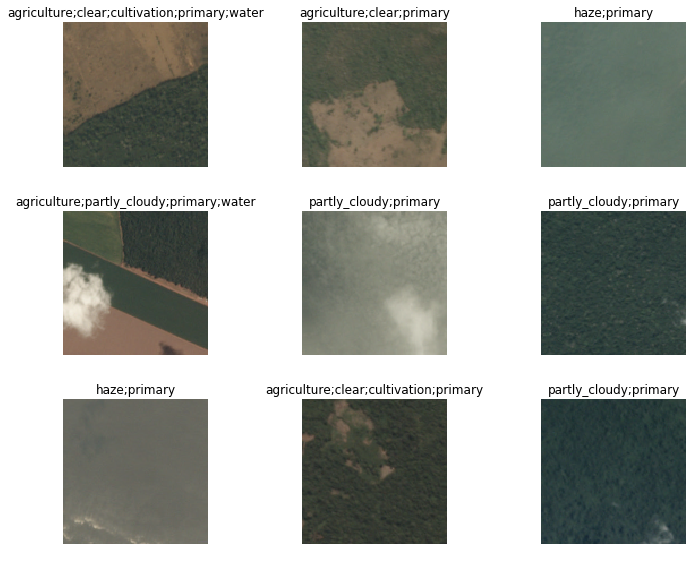

In [18]:
data.show_batch(rows=3, figsize=(10, 8))

## Model

We will be using restnet50 for our architecture this time.

In [19]:
arch = models.resnet50

We added some cool metrics to this model (which are the things that won't actually affect anything but they rather just print as we train it).

- fscore is what we are being rated at in kaggle. fscore tells us in a number how accurate a classifier is. kaggle is using **f2** which means it's beta is 2. However we do have to setup the **threshold** for our all the *data.c* from our model which basically is, in the result of our model, the bar that filters the results [0, 1] which are the correct categories from this one (instead of the regular argmax).

- acc_02 uses accuracy_threshold and works the same as regular accuracy but with a certain threshold instead of argmax.

In [20]:
thresh_use = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh_use)
f_score = partial(fbeta, thresh=thresh_use)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

### Finding a good learning rate

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


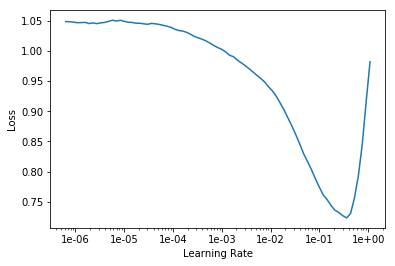

In [23]:
learn.recorder.plot()

So we can see that the steepest slope is at 1e-2, lets use that for our first training. 5 epoch and a learning rate of 1e-2.

### Training our model

In [27]:
lr = 0.01

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.106282,0.233924,0.958028,0.914995,03:14
1,0.103385,0.329631,0.951706,0.919329,03:14
2,0.102974,0.659182,0.954307,0.916047,03:14
3,0.097508,0.900605,0.956727,0.920641,03:14
4,0.093491,0.635052,0.955761,0.923567,03:14


So far, as we can see above, we've achived good results with a 0.9235 fbeta which means we are on the right track.

In [29]:
learn.save('stage-1-rn50')

#### Fine Tunning

Question:
Can we make our model learn in production?

Ans:
Yes, we should collect the user's correct response and then retrain our model (usually on fine tunning) with such mistakes. It's important to note that a good idea is to create a new databunch with only those that it got wrong and use that for the fine tunning. Here we should note that this is a very specials set of data since our model got all od them wrong or partially wrong at least; hence we might want to use at a slightly higher learing rate to make them kind of mean more or make them run at a few more epoch.

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


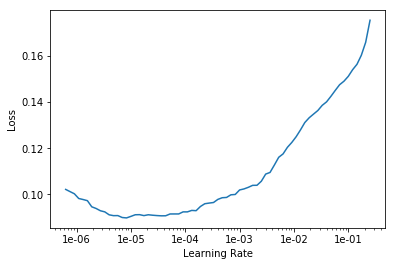

In [32]:
learn.lr_find()
learn.recorder.plot()

For the first training the *steepest slope* was found very easy however here it's more dificult. So a good *rule of thumb* thing to do is to take for the first part of the slice before it gets too high and go 1/10x that and for the second one our initial learning rate divided by 5 or 10. This are called discriminative learnign rates; we will look at them closer as the course continues.

In [33]:
learn.fit_one_cycle(5, slice(1e-6, lr/5.))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095977,0.356388,0.955491,0.921507,04:18
1,0.097479,0.096644,0.955841,0.924278,04:18
2,0.092318,0.362263,0.956073,0.923353,04:18
3,0.091889,0.104549,0.956851,0.925871,04:18
4,0.089028,0.086483,0.957606,0.927459,04:18


In [35]:
learn.save('stage-2-rn50')

Okay so we are at a very good fbeta now but, how can we make it better?

Well, for this we will use **transfered learning** and continue to fine tune our model.

It's important to note that we started with 128 by 128 images so our model is currently good at classifying such image sizes. So now let's create a model that predict 256 by 256 imgs starting with our previous model and finetunning that (so don't start again). This is quite interesting since if we've already trained quite a lot we (probably at the virge of overfitting) then we are basically creating a new dataset 4x bigger in this case so it's a totally different dataset as far as our convolutional nn concerns. So we will basically be loosing all the overfitting and restarting that.

In [36]:
data = src.transform(tfms, size=256).databunch().normalize(imagenet_stats)

In [40]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

Let's now freeze our model and start again with theis *new* dataset.

In [41]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


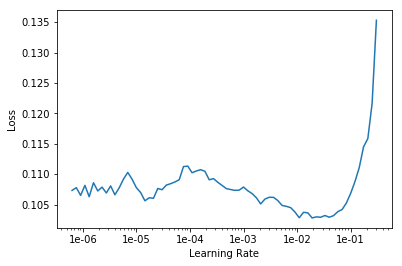

In [42]:
learn.lr_find()
learn.recorder.plot()

As we can see above we don't have a chart as obvious as the one from our first freezed traing and this is because our 128 by 128 model probably should be at least okay for our new 256 by 256 model so we pick an lr 1/10 x before it the loss starts growing.

In [44]:
lr = 1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093865,0.219786,0.954060,0.920760,11:07
1,0.094582,0.143212,0.956436,0.924479,11:03
2,0.090964,0.603469,0.956262,0.923245,11:04
3,0.090991,0.171547,0.957621,0.926342,11:04
4,0.088189,0.442610,0.957512,0.925040,11:04


In [45]:
learn.save('stage-1-256-rn50')

In [46]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5.))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093384,0.348607,0.957003,0.924056,14:37
1,0.093260,0.137084,0.956415,0.925211,14:32
2,0.092064,0.799107,0.958296,0.927733,14:33
3,0.083812,0.304511,0.958391,0.928934,14:32
4,0.087686,0.249203,0.959118,0.928264,14:33


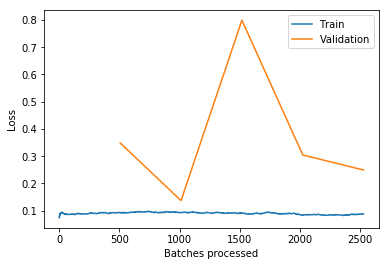

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-2-256-rn50')

# Lesson3 -> Segmentation : Camvid

Cambid is a dataset that utilizes images and classifies each pixel as belonging to some category. This categories could be: human, road, car, etc.

## Imports, configuration and path setup

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
path  = untar_data(URLs.CAMVID)
print(path)
path.ls()

/home/ubuntu/.fastai/data/camvid


[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f01980.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_006840.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f01710.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0001TP_008640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_07650_P.png')]

As we can see from above there's a maping from the name of the image to it's *label* by just adding a "_P" at the end of the image in the labels folder. 

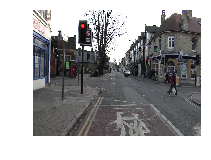

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show()

So what we do is just to creatae a function that takes the name of the image and adds a P at the end. One thing to note is that the labels are not just a regular image file but they rather use numbers to classify each pixel hence we treat it as a mask.

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

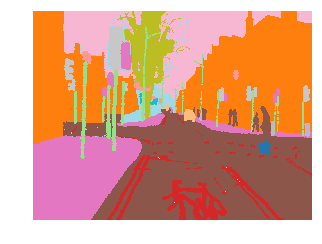

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha = 1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Datasets

In [17]:
from fastai.utils.mem import *

In [18]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


So lets create our data set, as before we create the source then the data. In the source the split for the validation set is already given to us since this are videos and using a random sample for our dataset will be cheating.

In [19]:
src = SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn, classes=codes)

Also something we should be telling our dataset is that we should also apply the same transformations we do on our x from our dataset to our y.

In [20]:
data = src.transform(get_transforms(), size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats)

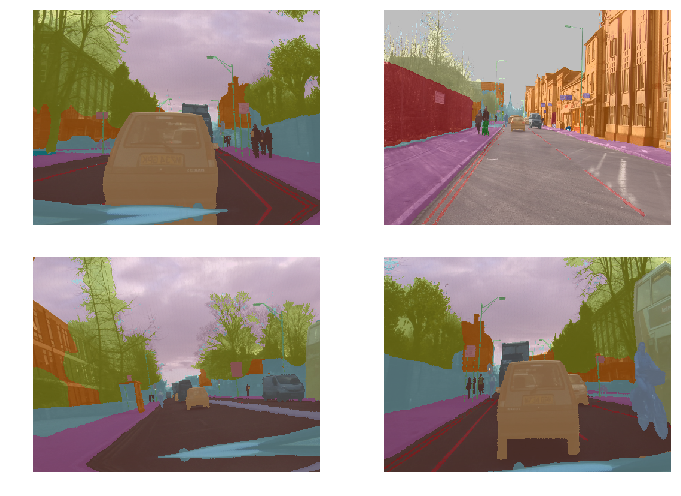

In [21]:
data.show_batch(2, figsize=(10, 7))

## Model

### Regular training

Lets create the model.

But first let's create the accuracy function for our metrics. Here the accuracy of our model 

In [25]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [26]:
metrics=acc_camvid

In [28]:
wd=1e-2

Instead of using a CNN for our learner we will be using a unet for this since it works better.

In [36]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


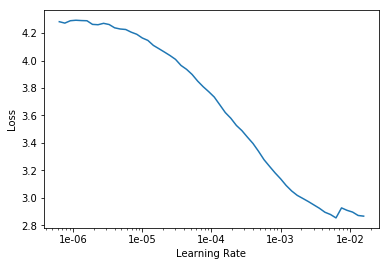

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr = 1e-4

In [24]:
lr_find??

In [25]:
learn.lr_find??

In [39]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.133703,1.059777,0.735389,03:35
1,1.121932,0.756988,0.817165,03:27
2,0.783468,0.564990,0.853532,03:27
3,0.651131,0.551154,0.855567,03:27
4,0.588100,0.522291,0.861542,03:27


In [40]:
learn.save('stage-1')

In [41]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [42]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


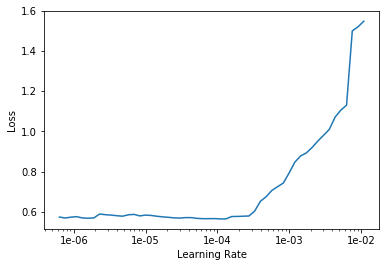

In [43]:
lr_find(learn)
learn.recorder.plot()

In [46]:
lrs = slice(1e-5, lr/5)

In [47]:
learn.fit_one_cycle(6, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.569503,0.505361,0.865039,03:34
1,0.554282,0.496207,0.867197,03:34
2,0.526825,0.466874,0.872056,03:35
3,0.493850,0.447031,0.877954,03:34
4,0.469180,0.440757,0.878009,03:34
5,0.456322,0.438455,0.878865,03:35


In [48]:
learn.save('stage-2')

### Learning Rate Changing

Here's something interesting, learn.recorder is where we keep track of everything happening in the model during training. **plot_losses()** keeps track of our training loss (blue) and validation loss (orange).

As we can see quite often they go up a bit before they go down. Why is that? **Look below.**

P.D. Something to note is that if after plotting losses our model starts getting a bit worse then it gets a lot better that means we've found a **very good learning rate.** If our plot losses instead looks like always decreasing (particularly after we unfreeze) then that probably means we can bump our learning rates a little bit since we really want to see this kinf of slope-ish shape on our loss plot.

Also what we are actually passing **fit_one_cycle** as a learnign rate is actually a maximum learning rate.

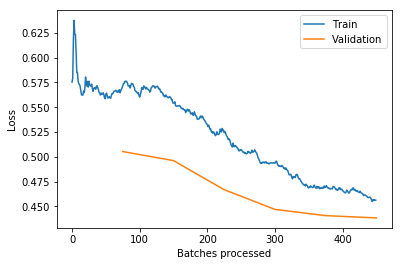

In [49]:
learn.recorder.plot_losses()

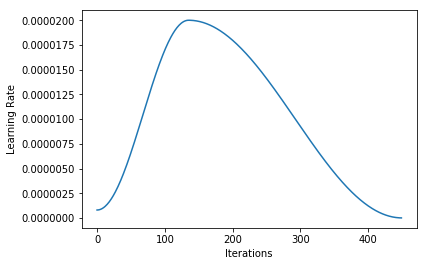

In [50]:
learn.recorder.plot_lr()

What we can do to figure out the above question is to plot our learning rate over time. One we plot our learning rate we can see that our learning rate goes up and then it goes down. Why? because that's what fit one cycle does. It makes the learning rate start low, go up and then go down again.

**Why is that a good idea?**

Well It would be good to explain this in 2 parts.

**Part 1: After the highest point.**

So after the highest point what happens is that we decrease our learning rate and this is called **learning rate anheling**.
So the way this works is that our loss function will likely look as the image below so at fist we want to have a sort of big leargning rate to be able to jump between the bumps in the loss.

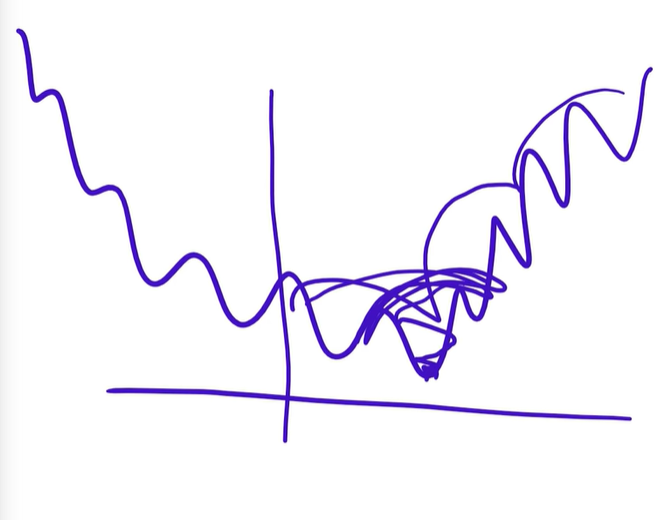

Then as the iterations pass and we get close to the best answer we should start decreasing our learning rate so that our actual loss converges to the best answer.

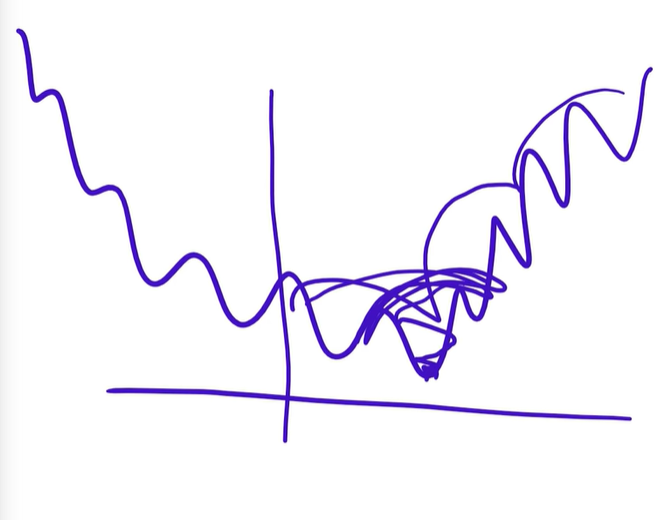

**Part 2: Before the highest point.**

So before whe reach the highest point what we are basically doing is increasing our learning rate.

Why does this work?

Well our loss functions usually look like this:

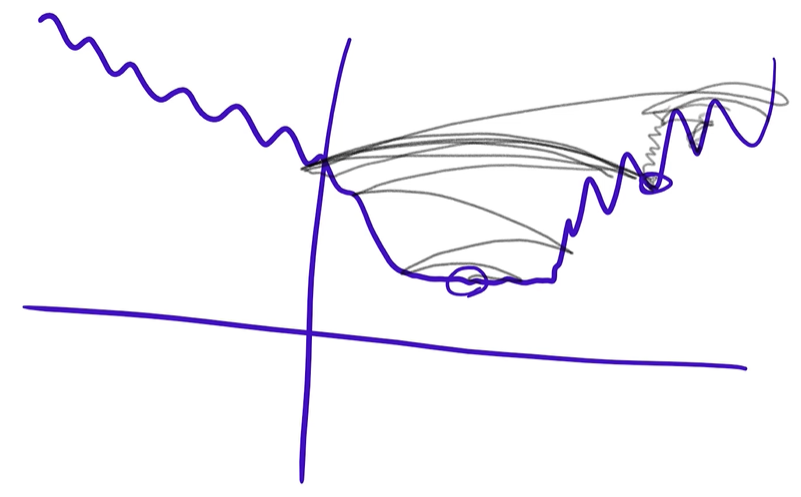

They have flat areas and bumpy areas. And if we get stuck at the bottom of a bumpy area then that solution won't generalize very well so in this case we wan't to land our loss function in the flat area.

So by increasing our learning rate it will allow us to sort of explore the loss function and center ourselves at the best answer to finally reduce the learning rate and converge to it as we saw before:
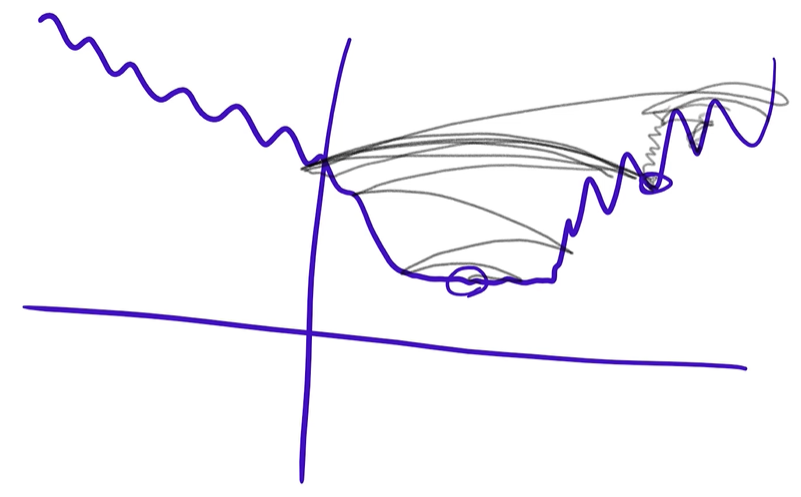

### Go big (imagewise)

Let's now increase our image size and see how good we can really get after loading the last weights we computed for our model.

In [22]:
#learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 11172MB of GPU RAM free


In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [30]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [31]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6, lr/10)

In [ ]:
learn.fit_one_cycle(5, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

# Lesson3 -> Point Center Head : BIWI

This is the BIWI dataset which has images of people. This dataset has several stuff in it but we will concentrate on the part where we have to place a dot in the center of the head of someone and we will try to predict such continious value. This is a regression model.

## Imports and initial configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

## Getting and converting the data

In [6]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [11]:
fname = '09/frame_00667_rgb.jpg'

In [12]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

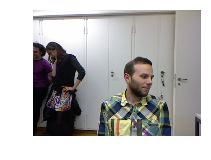

In [13]:
img = open_image(path/fname)
img.show()

In [14]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

Here we are creating the functions that transform the coordinates in the format they gave us to the picture format since they were taken by a kinect. This is in their readme files.

In [15]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [16]:
get_ctr(fname)

tensor([263.9104, 428.5814])

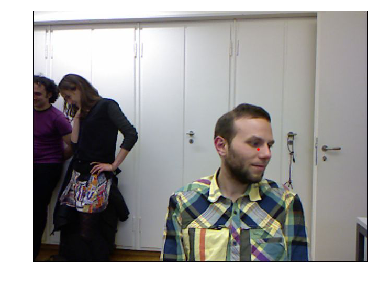

In [17]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

Here there are 2 important things to notice:
- We are making our validation set everything inside the '13' folder. This happens since evey folder contains vide footage.
- We are using the function we created above to get the 'labels' from every element in our training set. Here the 'label' would be the rank 1 tensor containing the coordinates of the point of every image.

In [19]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120, 160))
        .databunch().normalize(imagenet_stats))

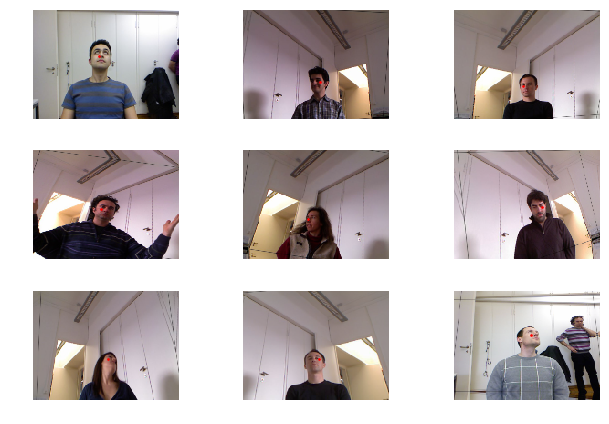

In [21]:
data.show_batch(3, figsize=(9, 6))

## Train model

So our model will be a cnn using resnet34. This is not neccesary anymore but we will be using MSELossFlat in this case.

In classification models (not like this one) we use crossentropy loss which measures if we predicted the correct class and how sure we were about it.

In [24]:
learn = cnn_learner(data, models.resnet34)
learn.loss_func = MSELossFlat()

In [26]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f99270c5208>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 19660800 bytes. Error code 12 (Cannot allocate memory)


In [27]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

So as we can see from above this already gave us a very good MSE.

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [ ]:
learn.show_results()